In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 9.7 MB/s 
     |████████████████████████████████| 9.8 MB 48.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
#from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima, ADFTest
import matplotlib.pylab as plt

# Importação do Dataset

In [4]:
# import directly from GitHub
df = pd.read_csv("https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv")
df.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Definindo dataset com os totais diários para o Brasil

In [5]:
# Ajusta tipo da coluna 'date' para data
df['date'] = pd.to_datetime(df['date'])

In [6]:
# Define novo dataset com os totais diários para o BRASIL

df_total = df[(df['state'] == 'TOTAL')]
df_total.reset_index(drop=True, inplace=True)

In [7]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   epi_week                               726 non-null    int64         
 1   date                                   726 non-null    datetime64[ns]
 2   country                                726 non-null    object        
 3   state                                  726 non-null    object        
 4   city                                   726 non-null    object        
 5   newDeaths                              726 non-null    int64         
 6   deaths                                 726 non-null    int64         
 7   newCases                               726 non-null    int64         
 8   totalCases                             726 non-null    int64         
 9   deathsMS                               726 non-null    int64     

In [8]:
df_total.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
0,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,2020-02-27,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,2020-02-28,Brazil,TOTAL,TOTAL,0,0,1,2,0,1,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2020-02-29,Brazil,TOTAL,TOTAL,0,0,0,2,0,2,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_total.tail()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
721,207,2022-02-15,Brazil,TOTAL,TOTAL,916,640118,123871,27684065,639689,27659052,300.07739,12977.86021,0.02312,24773656.0,8866327.0,69640999.0,32646.62,169637258.0,79.52331,147547875.0,69.16815,5028165.0,2.35713,57563050.0,26.98466
722,207,2022-02-16,Brazil,TOTAL,TOTAL,1033,641151,144273,27828338,640774,27806786,300.56164,13045.49316,0.02304,24773656.0,8866327.0,69640999.0,32646.62,169919345.0,79.65555,147722104.0,69.24983,5029667.0,2.35783,58207145.0,27.28661
723,207,2022-02-17,Brazil,TOTAL,TOTAL,1108,642259,129592,27957930,641902,27937835,301.08106,13106.24388,0.02297,24773656.0,8866327.0,69640999.0,32646.62,170176843.0,79.77626,147902602.0,69.33445,5032486.0,2.35915,59085835.0,27.69852
724,207,2022-02-18,Brazil,TOTAL,TOTAL,1081,643340,114308,28072238,643029,28058862,301.58781,13159.82969,0.02292,24781643.0,8866327.0,69640999.0,32646.62,170898569.0,80.11460,148223778.0,69.48501,5035417.0,2.36053,59955129.0,28.10603
725,207,2022-02-19,Brazil,TOTAL,TOTAL,0,643340,0,28072238,643029,28058862,301.58781,13159.82969,0.02292,24781643.0,8866327.0,69640999.0,32646.62,171032222.0,80.17725,148349449.0,69.54392,5036315.0,2.36095,60345947.0,28.28924


In [10]:
df_total.columns

Index(['epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deathsMS', 'totalCasesMS',
       'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants',
       'deaths_by_totalCases', 'recovered', 'suspects', 'tests',
       'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants'],
      dtype='object')

## Adição de novas features
**Features adicionadas:** newCasesMS, newDeathMS, day, month, year, day_of_week

In [11]:
# Definindo o número de casos e o número de mortes diários segundo o MS
df_total['newCasesMS'] = df_total['totalCasesMS'].diff()
df_total['newDeathsMS'] = df_total['deathsMS'].diff()

# Definindo o número de recuperados, suspeitos, testes, vacinados e vacinados pela segunda vez diários
df_total['newRecovered'] = df_total['recovered'].diff()
df_total['newSuspects'] = df_total['suspects'].diff()
df_total['newTests'] = df_total['tests'].diff()
df_total['newVaccinated'] = df_total['vaccinated'].diff()
df_total['newVaccinated_second'] = df_total['vaccinated_second'].diff()

# Ajustando o valor do primeiro elemento de cada nova coluna. A operação 'diff()' faz com que esses valaores sejam NAN.
df_total.loc[0,'newDeathsMS'] = 0
df_total.loc[0,'newCasesMS'] = 0

# Criando novas features baseadas na coluna 'date'
df_total['day'] = df_total['date'].dt.day
df_total['month'] = df_total['date'].dt.month
#df_total['year'] = df_total['date'].dt.year
df_total['day_of_week'] = df_total['date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [12]:
# Verificação da existência de valores negativos após o cálculo da primeira diferença.
# Isso pode ocorrer devido aos erros de preenchimento do dataset
features_list_diff = ['newCasesMS', 'newDeathsMS', 'newRecovered', 'newSuspects', 'newTests', 'newVaccinated', 'newVaccinated_second']
neg_cols = []

for col in features_list_diff:
  neg_check = df_total[df_total[col] < 0][col].count()

  if neg_check > 0:
    neg_cols.append(col)
    print(col,'--->',neg_check)
print('\nLista de colunas com valores negativos: \n', neg_cols)

newCasesMS ---> 1
newSuspects ---> 39
newTests ---> 1
newVaccinated ---> 1
newVaccinated_second ---> 1

Lista de colunas com valores negativos: 
 ['newCasesMS', 'newSuspects', 'newTests', 'newVaccinated', 'newVaccinated_second']


In [13]:
# Substituindo registros negativos pela mediana

print('Valores substituídos e mediana das colunas: \n')

for col in neg_cols:
  median_col = df_total[df_total[col] > 0][col].median()

  subs_list = df_total[df_total[col] < 0][col].to_list()
  print(col, '---> ', subs_list, '---> mediana: ', median_col)

  df_total[col] = df_total[col].replace(to_replace=subs_list, value=median_col)

Valores substituídos e mediana das colunas: 

newCasesMS --->  [-573.0] ---> mediana:  30550.0
newSuspects --->  [-903.0, -404.0, -2896.0, -406.0, -1836.0, -14266.0, -19096.0, -2963.0, -2584.0, -16823.0, -1847.0, -2293.0, -4141.0, -1319.0, -17762.0, -642.0, -2333.0, -21240.0, -37942.0, -3247.0, -1009.0, -38306.0, -5567.0, -274.0, -1381.0, -268.0, -4330.0, -1283.0, -3125.0, -409.0, -1423.0, -547.0, -1565.0, -76.0, -74376.0, -600.0, -7424.0, -5135.0, -2625.0] ---> mediana:  7370.5
newTests --->  [-92358.0] ---> mediana:  66592.0
newVaccinated --->  [-158674.0] ---> mediana:  287991.0
newVaccinated_second --->  [-203052.0] ---> mediana:  256315.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [14]:
# Definindo coluna 'date' como index
df_total.set_index(df_total['date'], inplace=True)

## Removendo colunas e reordenando as demais

In [15]:
# Removendo colunas não desejadas
df_total = df_total.drop(['epi_week', 'country', 'state', 'city', 'date'], axis=1)

In [16]:
df_total.columns

Index(['newDeaths', 'deaths', 'newCases', 'totalCases', 'deathsMS',
       'totalCasesMS', 'deaths_per_100k_inhabitants',
       'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', 'recovered',
       'suspects', 'tests', 'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants', 'newCasesMS', 'newDeathsMS',
       'newRecovered', 'newSuspects', 'newTests', 'newVaccinated',
       'newVaccinated_second', 'day', 'month', 'day_of_week'],
      dtype='object')

In [17]:
# Reordenando as colunas
new_order = [ 'month', 'day', 'day_of_week', 'newDeaths', 'deaths', 'newCases', 'totalCases', 'newDeathsMS', 'deathsMS',
              'newCasesMS', 'totalCasesMS', 'deaths_per_100k_inhabitants',
              'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', 'newRecovered', 'recovered', 'newSuspects', 
              'suspects', 'newTests', 'tests', 'tests_per_100k_inhabitants', 'newVaccinated', 'vaccinated',
              'vaccinated_per_100_inhabitants', 'newVaccinated_second', 'vaccinated_second',
              'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
              'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
              'vaccinated_third_per_100_inhabitants']

df_total = df_total[new_order]

In [18]:
df_total.head()

,month,day,day_of_week,newDeaths,deaths,newCases,totalCases,newDeathsMS,deathsMS,newCasesMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,newRecovered,recovered,newSuspects,suspects,newTests,tests,tests_per_100k_inhabitants,newVaccinated,vaccinated,vaccinated_per_100_inhabitants,newVaccinated_second,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-25,2,25,1,0,0,1,1,0.0,0,0.0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,2,26,2,0,0,0,1,0.0,0,1.0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,2,27,3,0,0,0,1,0.0,0,0.0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,2,28,4,0,0,1,2,0.0,0,0.0,1,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,2,29,5,0,0,0,2,0.0,0,1.0,2,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_total.tail()

,month,day,day_of_week,newDeaths,deaths,newCases,totalCases,newDeathsMS,deathsMS,newCasesMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,newRecovered,recovered,newSuspects,suspects,newTests,tests,tests_per_100k_inhabitants,newVaccinated,vaccinated,vaccinated_per_100_inhabitants,newVaccinated_second,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-15,2,15,1,916,640118,123871,27684065,854.0,639689,120549.0,27659052,300.07739,12977.86021,0.02312,2740927.0,24773656.0,0.0,8866327.0,1951029.0,69640999.0,32646.62,233919.0,169637258.0,79.52331,82339.0,147547875.0,69.16815,5028165.0,2.35713,57563050.0,26.98466
2022-02-16,2,16,2,1033,641151,144273,27828338,1085.0,640774,147734.0,27806786,300.56164,13045.49316,0.02304,0.0,24773656.0,0.0,8866327.0,0.0,69640999.0,32646.62,282087.0,169919345.0,79.65555,174229.0,147722104.0,69.24983,5029667.0,2.35783,58207145.0,27.28661
2022-02-17,2,17,3,1108,642259,129592,27957930,1128.0,641902,131049.0,27937835,301.08106,13106.24388,0.02297,0.0,24773656.0,0.0,8866327.0,0.0,69640999.0,32646.62,257498.0,170176843.0,79.77626,180498.0,147902602.0,69.33445,5032486.0,2.35915,59085835.0,27.69852
2022-02-18,2,18,4,1081,643340,114308,28072238,1127.0,643029,121027.0,28058862,301.58781,13159.82969,0.02292,7987.0,24781643.0,0.0,8866327.0,0.0,69640999.0,32646.62,721726.0,170898569.0,80.11460,321176.0,148223778.0,69.48501,5035417.0,2.36053,59955129.0,28.10603
2022-02-19,2,19,5,0,643340,0,28072238,0.0,643029,0.0,28058862,301.58781,13159.82969,0.02292,0.0,24781643.0,0.0,8866327.0,0.0,69640999.0,32646.62,133653.0,171032222.0,80.17725,125671.0,148349449.0,69.54392,5036315.0,2.36095,60345947.0,28.28924


In [20]:
# from pandas_profiling import ProfileReport
# relatorio_completo = ProfileReport(df_total, title='Relatorio Completo')
# relatorio_completo.to_file('relatorio_completo.html')

## Definição dos Conjuntos de Treino e Teste

Divisão por períodos:
* Treino: 2021-01-01 a 2022-01-31
* Teste: 2022-02-01 a 2022-02-10

In [21]:
df_train = df_total.loc['2021-03-15':'2022-01-31', df_total.columns]
df_train = df_train.sort_index() # Reordena o dataset através do index depois de ter feito a filtragem

df_test = df_total.loc['2022-02-01':'2022-02-10', df_total.columns]
df_test = df_test.sort_index()

In [22]:
print('Dimensões do conjunto de treino: ', df_train.shape)
print('Dimensões do conjunto de teste: ', df_test.shape)

Dimensões do conjunto de treino:  (323, 31)
Dimensões do conjunto de teste:  (10, 31)


## Correlações

In [23]:
round(df_train.corr(), 2)

,month,day,day_of_week,newDeaths,deaths,newCases,totalCases,newDeathsMS,deathsMS,newCasesMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,newRecovered,recovered,newSuspects,suspects,newTests,tests,tests_per_100k_inhabitants,newVaccinated,vaccinated,vaccinated_per_100_inhabitants,newVaccinated_second,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
month,1.00,-0.05,0.00,-0.50,0.53,-0.73,0.46,-0.48,0.53,-0.71,0.46,0.53,0.46,0.58,-0.20,0.52,-0.07,0.43,-0.02,0.47,0.47,-0.12,0.52,0.52,0.43,0.37,0.37,0.13,0.13,-0.62,-0.62
day,-0.05,1.00,-0.02,0.02,-0.01,0.15,0.02,0.01,-0.01,0.15,0.02,-0.01,0.02,-0.16,-0.02,0.00,-0.02,0.00,-0.02,0.01,0.01,0.02,0.01,0.01,0.02,0.03,0.03,0.05,0.05,0.23,0.23
day_of_week,0.00,-0.02,1.00,-0.07,0.02,-0.02,0.02,-0.03,0.02,0.02,0.02,0.02,0.02,0.02,-0.12,0.02,-0.02,0.02,-0.04,0.02,0.02,-0.28,0.01,0.01,-0.26,0.01,0.01,-0.02,-0.02,-0.00,-0.00
newDeaths,-0.50,0.02,-0.07,1.00,-0.86,0.50,-0.86,0.99,-0.86,0.50,-0.86,-0.86,-0.86,-0.39,0.39,-0.87,0.07,-0.85,0.08,-0.85,-0.85,0.44,-0.87,-0.87,-0.25,-0.79,-0.79,-0.71,-0.71,-0.33,-0.33
deaths,0.53,-0.01,0.02,-0.86,1.00,-0.34,0.99,-0.84,1.00,-0.34,0.99,1.00,0.99,0.56,-0.34,0.99,-0.06,0.98,-0.09,0.96,0.96,-0.23,0.96,0.96,0.37,0.83,0.83,0.83,0.83,0.90,0.90
newCases,-0.73,0.15,-0.02,0.50,-0.34,1.00,-0.25,0.50,-0.35,0.99,-0.25,-0.34,-0.25,-0.54,0.19,-0.34,0.12,-0.25,0.01,-0.29,-0.29,0.20,-0.35,-0.35,-0.33,-0.22,-0.22,-0.08,-0.08,0.64,0.64
totalCases,0.46,0.02,0.02,-0.86,0.99,-0.25,1.00,-0.84,0.99,-0.25,1.00,0.99,1.00,0.43,-0.34,0.99,-0.06,0.99,-0.09,0.97,0.97,-0.27,0.97,0.97,0.34,0.87,0.87,0.74,0.74,0.93,0.93
newDeathsMS,-0.48,0.01,-0.03,0.99,-0.84,0.50,-0.84,1.00,-0.84,0.51,-0.84,-0.84,-0.84,-0.38,0.38,-0.86,0.08,-0.84,0.09,-0.83,-0.83,0.42,-0.86,-0.86,-0.26,-0.78,-0.78,-0.71,-0.71,-0.34,-0.34
deathsMS,0.53,-0.01,0.02,-0.86,1.00,-0.35,0.99,-0.84,1.00,-0.34,0.99,1.00,0.99,0.56,-0.34,0.99,-0.06,0.98,-0.09,0.96,0.96,-0.23,0.96,0.96,0.37,0.83,0.83,0.83,0.83,0.90,0.90
newCasesMS,-0.71,0.15,0.02,0.50,-0.34,0.99,-0.25,0.51,-0.34,1.00,-0.25,-0.34,-0.25,-0.53,0.18,-0.34,0.12,-0.25,0.01,-0.29,-0.29,0.19,-0.35,-0.35,-0.33,-0.22,-0.22,-0.09,-0.09,0.63,0.63


# Preparação dos dados para o Modelo de Machine Learning

## Seleção de Features e definição do Target

In [24]:
# Target
target_label = 'newDeathsMS' #'newDeathsMS' #'recovered' #'newRecovered' #'newCasesMS'

y_train = df_train[[target_label]]
y_test = df_test[[target_label]]

# Features
'''
features_names = ['month', 'day', 'day_of_week', 'newDeathsMS','newCasesMS', 'deaths_per_100k_inhabitants',
                  'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', 'newRecovered', 'newSuspects', 'newTests', 
                  'tests_per_100k_inhabitants', 'newVaccinated', 'vaccinated_per_100_inhabitants', 'newVaccinated_second',
                  'vaccinated_second_per_100_inhabitants']
'''
features_names = ['day', 'month', 'day_of_week', 'newDeathsMS', 'newCasesMS', 'suspects', 'newSuspects', 'recovered', 
                  'suspects', 'newRecovered', 'tests', 'vaccinated', 'vaccinated_second'] #, 'vaccinated_single', 'vaccinated_third']

features_names.remove(target_label)

X_train = df_train[features_names]
X_test = df_test[features_names]

In [25]:
y_test.info

<bound method DataFrame.info of             newDeathsMS
date                   
2022-02-01        929.0
2022-02-02        893.0
2022-02-03       1041.0
2022-02-04        493.0
2022-02-05       1308.0
2022-02-06        391.0
2022-02-07        428.0
2022-02-08       1189.0
2022-02-09          0.0
2022-02-10       2207.0>

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 323 entries, 2021-03-15 to 2022-01-31
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day                323 non-null    int64  
 1   month              323 non-null    int64  
 2   day_of_week        323 non-null    int64  
 3   newCasesMS         323 non-null    float64
 4   suspects           323 non-null    float64
 5   newSuspects        323 non-null    float64
 6   recovered          323 non-null    float64
 7   suspects           323 non-null    float64
 8   newRecovered       323 non-null    float64
 9   tests              323 non-null    float64
 10  vaccinated         323 non-null    float64
 11  vaccinated_second  323 non-null    float64
dtypes: float64(9), int64(3)
memory usage: 32.8 KB


In [27]:
# Descrição das features selecionadas
pd.options.display.float_format = '{:.2f}'.format

X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
day,323.00,16.18,8.83,1.00,9.00,16.00,24.00,31.00
month,323.00,7.07,3.29,1.00,5.00,7.00,10.00,12.00
day_of_week,323.00,2.99,2.01,0.00,1.00,3.00,5.00,6.00
newCasesMS,323.00,43264.70,40957.57,1419.00,12949.50,31359.00,69385.00,269968.00
suspects,323.00,7318628.67,996471.80,5115676.00,6655234.00,7958935.00,7958935.00,8866327.00
newSuspects,323.00,11611.92,69558.47,0.00,0.00,0.00,0.00,684678.00
recovered,323.00,17669988.90,3452392.75,10196596.00,14846553.50,18910110.00,20747506.00,21651890.00
suspects,323.00,7318628.67,996471.80,5115676.00,6655234.00,7958935.00,7958935.00,8866327.00
newRecovered,323.00,35638.76,49979.85,0.00,0.00,16009.00,53421.00,357041.00
tests,323.00,56026267.93,8351296.88,37907905.00,49811611.00,56636459.00,64755932.00,66606202.00


In [28]:
# Descrição da variável alvo
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
newDeathsMS,323.00,1080.21,1025.19,24.00,250.50,731.00,1656.50,4249.00


In [29]:
# Pipeline para preparação das variáveis numéricas

numeric_pipeline = Pipeline(steps=[
                                   ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                   #('normalization', MinMaxScaler())
])

In [30]:
# Ajustando variáveis numéricas usando o pipeline

X_train_prepared = numeric_pipeline.fit_transform(X_train)
y_train_prepared = numeric_pipeline.fit_transform(y_train)

X_test_prepared = numeric_pipeline.fit_transform(X_test)
y_test_prepared = numeric_pipeline.fit_transform(y_test)

# Implementação do ARIMA

In [31]:
# Teste de estacionariedade
adf_test = ADFTest(alpha=0.05)
result_adf_test = adf_test.should_diff(y_train_prepared)

print('Resultado do teste: ', result_adf_test)

if result_adf_test[1]:
  print('\nDados estacionários')
else:
  print('Dados não estacionários, verificar parâmetro d no modelo')

Resultado do teste:  (0.99, True)

Dados estacionários


In [42]:
model = auto_arima(y=y_train_prepared, X=None, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=15, max_q=15, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      information_criterion='aic',
                      scoring='mse' #'mae'
                  )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4913.851, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5001.177, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5003.339, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5003.181, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4999.185, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4850.825, Time=1.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4948.514, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4850.455, Time=1.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4946.824, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4789.888, Time=1.76 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4920.291, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4671.639, Time=1.29 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4757.245, Time=0.15 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=4530.979, Time=1.37 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept

In [43]:
# Predições
y_predicted = model.predict(n_periods=len(y_test_prepared)) #, X=X_test_prepared)
print(y_predicted)

[487.21945974 574.19159278 659.59099581 766.16323486 628.91297455
 351.64991718 309.6819587  489.94914151 577.00432631 648.8215849 ]


In [44]:
# Métricas para o conjunto de testes
def test_metrics(y_pred, y_test):
  mae = mean_absolute_error(y_pred, y_test)
  mape = mean_absolute_percentage_error(y_pred, y_test)
  mse = mean_squared_error(y_pred, y_test)
  rmse = np.sqrt(mse)
      
  print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Mean Absolute Percentage Error (MAPE): {mape.mean():.3f} +/- {mape.std():.3f}\n"
        f"Mean Squared Error (MSE): {mse.mean():.3f} +/- {mse.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}"
       )

print("Variável Alvo: ", target_label, '\n') 
test_metrics(y_predicted, y_test_prepared)

Variável Alvo:  newDeathsMS 

Mean Absolute Error (MAE):     508.615 +/- 0.000
Mean Absolute Percentage Error (MAPE): 0.880 +/- 0.000
Mean Squared Error (MSE): 424313.267 +/- 0.000
Root Mean Squared Error (RMSE): 651.393 +/- 0.000


In [45]:
# Comparação dos resultados
print('(Teste, Previsão) --- Previsão-Teste')

for pair in zip(np.reshape(y_test_prepared, len(y_test_prepared)), np.round(y_predicted,0)):
  print(pair, '---', pair[1]-pair[0])

(Teste, Previsão) --- Previsão-Teste
(929.0, 487.0) --- -442.0
(893.0, 574.0) --- -319.0
(1041.0, 660.0) --- -381.0
(493.0, 766.0) --- 273.0
(1308.0, 629.0) --- -679.0
(391.0, 352.0) --- -39.0
(428.0, 310.0) --- -118.0
(1189.0, 490.0) --- -699.0
(0.0, 577.0) --- 577.0
(2207.0, 649.0) --- -1558.0


In [46]:
# Transformação do array de predições em df pandas para incluir no gráfico juntamente com os df de treino e teste
df_prediction = pd.DataFrame(y_predicted, index=y_test.index)
df_prediction.columns = [target_label]
df_prediction

,newDeathsMS
date,
2022-02-01,487.22
2022-02-02,574.19
2022-02-03,659.59
2022-02-04,766.16
2022-02-05,628.91
2022-02-06,351.65
2022-02-07,309.68
2022-02-08,489.95
2022-02-09,577.00


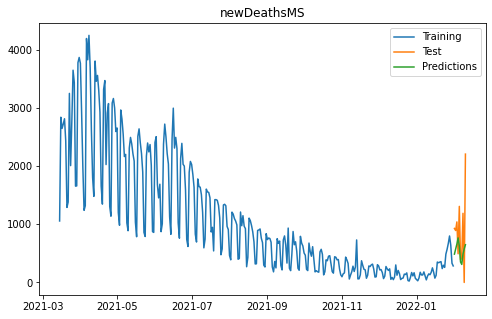

In [47]:
# Plotando o gráfico incluindo dados de treino, teste, e predições.

plt.figure(figsize=(8,5))
plt.title(target_label)
plt.plot(y_train, label = 'Training')
plt.plot(y_test, label = 'Test')
plt.plot(df_prediction, label = 'Predictions')
plt.legend();